In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
%load_ext autoreload
%autoreload 2
from helpers import *

In [2]:
dataset_file_path = "data_train.csv"
ratings = load_data(dataset_file_path)
print('Shape of ratings matrix:', ratings.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (10000, 1000)


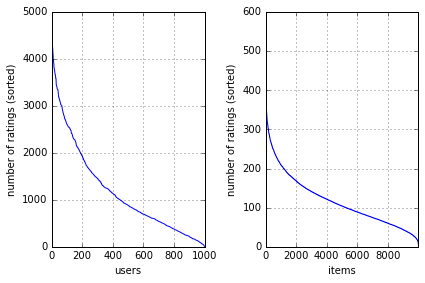

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [4]:
def init_MF_random(train, num_features):
    """
        Initialize randomly the matrices W and Z of matrix factorization.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    item_features = np.random.random((train.shape[0],num_features)) # W matrix initialization
    user_features = np.random.random((train.shape[1],num_features)) # Z matrix initialization
    
    return item_features, user_features

In [5]:
# define parameters
num_features = 50 # number of latent features in matrix factorization
lambda_item = 0.0 # regularization parameter for item features
lambda_user = 0.0 # regularization parameter for user features
num_epochs = 20 # number of iterations of ALS

# set random seed
np.random.seed(988)

# initialize matrices W and Z
item_features, user_features = init_MF_random(ratings, num_features)

def nonzero_indices(matrix):
    nz_row, nz_col = matrix.nonzero()
    return list(zip(nz_row, nz_col))

# find the non-zero ratings indices in the training set
nonzero_indices = nonzero_indices(ratings)

# initialize matrices used to compute RMSE
train_label = np.zeros(len(nonzero_indices))
prediction_label = np.zeros(len(nonzero_indices))

# initialize accumulator for RMSE of every iteration
rmse_train = np.zeros(num_epochs)

In [6]:
def compute_ALS(ratings, nonzero_indices, item_features, user_features, num_features, num_epochs):
    lambda_user_diag = np.identity(num_features)
    np.fill_diagonal(lambda_user_diag, lambda_user)
    lambda_item_diag = np.identity(num_features)
    np.fill_diagonal(lambda_item_diag, lambda_user)
    
    for it in range(num_epochs):
        begin = datetime.datetime.now() # start time measurement
        
        print("Epoch:", it)

        # perform one iteteration of the algorithm
        
        # first fix item features: Z^T = (W^T*W + (lambda_z*I_K)^(-1)*W^T*X)
        user_features = (np.linalg.inv(item_features.T.dot(item_features) + lambda_user_diag).dot(item_features.T.dot(ratings))).T
        # then fix user features: W^T = (Z^T*Z + (lambda_w*I_K)^(-1)*Z^T*X^T)
        item_features = (np.linalg.inv(user_features.T.dot(user_features) + lambda_item_diag).dot(user_features.T.dot(ratings.T))).T

        # calculate training RMSE
        for i in range(len(nonzero_indices)):
            train_label[i] = ratings[nonzero_indices[i][0], nonzero_indices[i][1]]
            prediction_label[i] = item_features[nonzero_indices[i][0], :].dot(user_features.T[:, nonzero_indices[i][1]])

        # store RMSE of current iteration
        rmse_train[it] = calculate_mse(train_label, prediction_label)
        
        print("RMSE on training set:", rmse_train[it])

        end = datetime.datetime.now() # stop time measurement
        
        # compute the time of the iteration
        execution_time = (end - begin).total_seconds()
        print("Execution time:", execution_time)

        print("*" * 50)
    
    return item_features.dot(user_features.T)

In [11]:
ratings_dense = scipy.sparse.lil_matrix.todense(ratings)

# normalize rows of ratings matrix by substracting mean (bias) rating for each movie
v = np.nanmean(np.where(ratings_dense != 0, ratings_dense, np.nan), axis = 0)
v = v[:, np.newaxis].T
print(v[0,:5])
print(ratings_dense[:5, :5])
ratings_subst = ratings_dense - v
for i, j in nonzero_indices:
    ratings_dense[i, j] = ratings_subst[i, j]
print(ratings_dense[:5, :5])

prediction = compute_ALS(ratings_dense, nonzero_indices, item_features, user_features, num_features, num_epochs)

[ 3.37941176  3.50094162  3.48358586  3.93647282  3.55913113]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.]
 [ 0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.93647282  0.        ]
 [ 0.          0.          0.         -1.93647282  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.50094162  0.          0.          0.        ]]
Epoch: 0
RMSE on training set: 0.94565082971
Execution time: 29.519574
**************************************************
Epoch: 1
RMSE on training set: 0.906160232594
Execution time: 29.678204
**************************************************
Epoch: 2
RMSE on training set: 0.89673451047
Execution time: 30.452674
**************************************************
Epoch: 3
RMSE on training set: 0.893760045092
Execution time: 40.520427
**************************************************
Epoch: 4
RMSE on

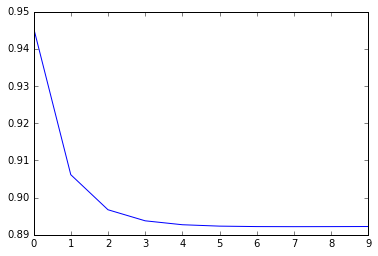

In [12]:
plt.plot(rmse_train[:10])

In [15]:
def create_csv_submission(prediction, submission_file_path = "submission.csv"):
    """
        Creates an output file in csv format for submission to kaggle.

        Arguments:
            prediction: matrix W * Z^T
            submission_file_path: string name of .csv output file to be created
    """

    dataset_file_path = "sampleSubmission.csv" # file path to the dataset of the entries to be predicted
    sample_ratings = load_data(dataset_file_path)
    
    # find the non-zero ratings indices 
    nz_row_sr, nz_col_sr = sample_ratings.nonzero()
    nz_sr = list(zip(nz_row_sr, nz_col_sr))
    
    submission_file_path = time.strftime("%Y%m%d_%H%M") + " " + submission_file_path
    with open(submission_file_path, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for i, j in nz_sr:
            writer.writerow({'Id' : 'r' + str(i + 1) + '_' + 'c' + str(j + 1),
                             'Prediction' : str(prediction[i, j])})

In [14]:
# denormalize rows of ratings matrix by adding back mean (bias) rating for each movie
prediction_added = prediction + v
for i, j in nonzero_indices:
    prediction[i, j] = prediction_added[i, j]

create_csv_submission(prediction)

number of items: 1000, number of users: 1000


In [18]:
ratings_dense[:10,:10]

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.3539283 ],
        [ 0.        ,  0.        ,  0.        , -0.93647282,  0.        ,
          0.31723027,  0.        ,  0.12250294,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -1.93647282,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -1.50094162,  0.        ,  0.        ,  0.        ,
          0.31723027,  0.        , -0.87749706,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.31723027,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.       